In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [71]:
df = pd.read_csv('/content/European_Bank.csv')
df.head()

,Year,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,2025,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2025,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,2025,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,2025,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,2025,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [72]:
print("Missing values per column:\n", df.isnull().sum())
print("\nData types of each column:\n", df.dtypes)
print("\nUnique values for 'HasCrCard':", df['HasCrCard'].unique())
print("Unique values for 'IsActiveMember':", df['IsActiveMember'].unique())
print("Unique values for 'Exited':", df['Exited'].unique())
print("\nDistribution of 'NumOfProducts':\n", df['NumOfProducts'].value_counts())

Missing values per column:
 Year               0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Data types of each column:
 Year                 int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Unique values for 'HasCrCard': [1 0]
Unique values for 'IsActiveMember': [1 0]
Unique values for 'Exited': [1 0]

Distribution of 'NumOfProducts':
 NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


In [73]:
# Calculate average balance by IsActiveMember and Exited status
mean_balance_grouped = df.groupby(['IsActiveMember', 'Exited'])['Balance'].mean().unstack()

# Identify at-risk premium customers (e.g., high balance, not yet churned)
high_balance_threshold = df['Balance'].quantile(0.75) # Top 25% of balances
at_risk_premium_customers = df[(df['Balance'] > high_balance_threshold) & (df['Exited'] == 0)]

# Calculate churn rate for sticky customers
# Assuming 'Sticky Customers' engagement profile is already defined in df
if 'Engagement_Profile' in df.columns:
    sticky_churn_rate = df[df['Engagement_Profile'] == 'Sticky Customers']['Exited'].mean()
else:
    # Recalculate if Engagement_Profile is not present (e.g., if a previous cell was not run)
    def create_engagement_profile(row):
        if row['IsActiveMember'] == 1 and row['NumOfProducts'] == 2:
            return 'Sticky Customers'
        elif row['IsActiveMember'] == 0 and row['NumOfProducts'] == 1:
            return 'Inactive & Disengaged'
        elif row['IsActiveMember'] == 1 and row['NumOfProducts'] == 1:
            return 'Active but Low-Product'
        elif row['IsActiveMember'] == 0 and row['NumOfProducts'] > 1:
            return 'Inactive but Multi-Product'
        elif row['IsActiveMember'] == 1 and row['NumOfProducts'] > 2:
            return 'Active & Engaged'
        else:
            return 'Other'
    df['Engagement_Profile'] = df.apply(create_engagement_profile, axis=1)
    sticky_churn_rate = df[df['Engagement_Profile'] == 'Sticky Customers']['Exited'].mean()

# Combine all churn rates for a comprehensive view
churn_rates_all = df.groupby('Engagement_Profile')['Exited'].mean().sort_values(ascending=False)


In [74]:
def create_engagement_profile(row):
    if row['IsActiveMember'] == 1 and row['NumOfProducts'] == 2:
        return 'Sticky Customers'
    elif row['IsActiveMember'] == 0 and row['NumOfProducts'] == 1:
        return 'Inactive & Disengaged'
    elif row['IsActiveMember'] == 1 and row['NumOfProducts'] == 1:
        return 'Active but Low-Product'
    elif row['IsActiveMember'] == 0 and row['NumOfProducts'] > 1:
        return 'Inactive but Multi-Product'
    elif row['IsActiveMember'] == 1 and row['NumOfProducts'] > 2:
        return 'Active & Engaged'
    else:
        return 'Other'

df['Engagement_Profile'] = df.apply(create_engagement_profile, axis=1)

# Calculate churn rate by engagement profile
churn_rates = df.groupby('Engagement_Profile')['Exited'].mean().sort_values(ascending=False)

# Calculate churn rate by number of products
churn_rate_by_products = df.groupby('NumOfProducts')['Exited'].mean().sort_values(ascending=False)

# Define product categories (Single-Product vs. Multi-Product)
df['ProductCategory'] = df['NumOfProducts'].apply(lambda x: 'Single-Product' if x == 1 else 'Multi-Product')

# Calculate churn rate by product category
churn_rate_by_category = df.groupby('ProductCategory')['Exited'].mean().sort_values(ascending=False)

print("Churn Rate by Engagement Profile:\n", churn_rates)
print("\nChurn Rate by Number of Products:\n", churn_rate_by_products)
print("\nChurn Rate by Product Category:\n", churn_rate_by_category)

Churn Rate by Engagement Profile:
 Engagement_Profile
Active & Engaged              0.802817
Inactive & Disengaged         0.366521
Active but Low-Product        0.189231
Inactive but Multi-Product    0.162371
Sticky Customers              0.055601
Name: Exited, dtype: float64

Churn Rate by Number of Products:
 NumOfProducts
4    1.000000
3    0.827068
1    0.277144
2    0.075817
Name: Exited, dtype: float64

Churn Rate by Product Category:
 ProductCategory
Single-Product    0.277144
Multi-Product     0.127746
Name: Exited, dtype: float64


**Reasoning**:
To visualize the churn rates for each engagement profile, I will create a bar chart using the `churn_rates` Series, setting appropriate labels, title, and rotating x-axis labels for readability.



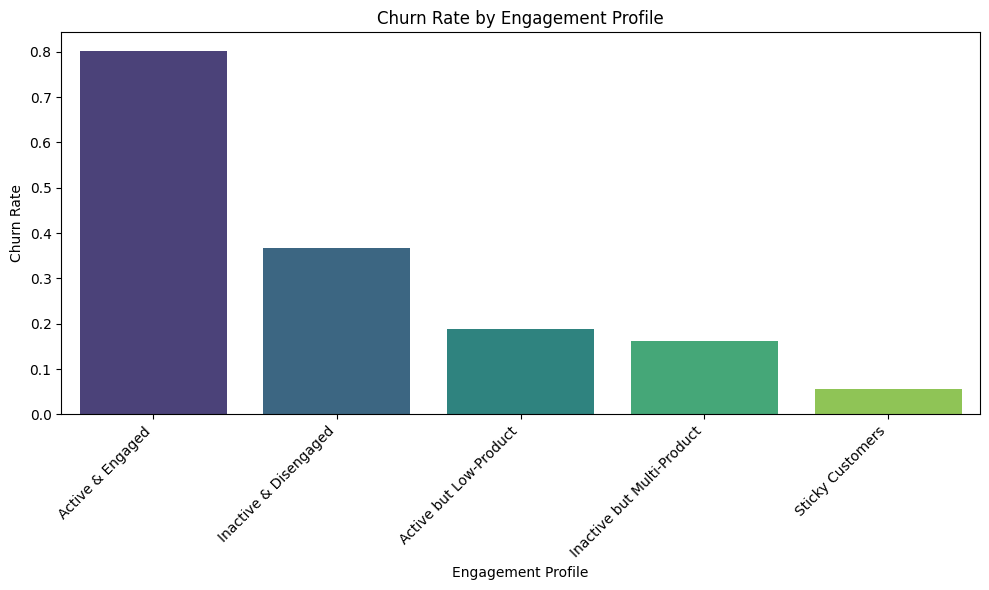

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values, hue=churn_rates.index, palette='viridis', legend=False)
plt.xlabel('Engagement Profile')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Engagement Profile')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
To visualize the churn rates based on the number of products and product categories, I will generate two bar charts: one for 'churn_rate_by_products' and another for 'churn_rate_by_category', ensuring both have clear labels and titles.



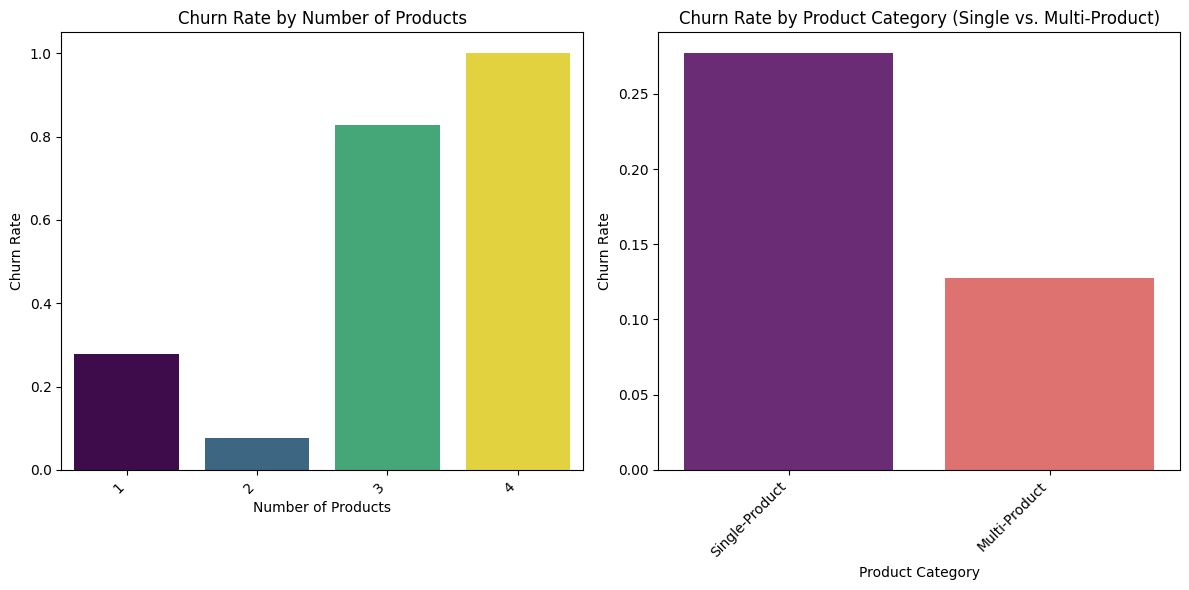

In [76]:
plt.figure(figsize=(12, 6))

# Plot for Churn Rate by Number of Products
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.barplot(x=churn_rate_by_products.index, y=churn_rate_by_products.values, hue=churn_rate_by_products.index, palette='viridis', legend=False)
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Number of Products')
plt.xticks(rotation=45, ha='right')

# Plot for Churn Rate by Product Category (Single vs. Multi-Product)
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.barplot(x=churn_rate_by_category.index, y=churn_rate_by_category.values, hue=churn_rate_by_category.index, palette='magma', legend=False)
plt.xlabel('Product Category')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Product Category (Single vs. Multi-Product)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Reasoning**:
The first instruction is to display the `mean_balance_grouped` Series, which provides average balance information grouped by active/inactive and churned/retained customer segments. This series is already available in the kernel state.



In [77]:
print("Average Balance by IsActiveMember and Exited status:\n", mean_balance_grouped)

Average Balance by IsActiveMember and Exited status:
 Exited                     0             1
IsActiveMember                            
0               72048.820578  90988.807081
1               73304.717314  91320.636476


**Reasoning**:
The next step is to create a box plot visualizing the distribution of 'Balance' based on 'IsActiveMember' status and 'Exited' status, as well as a scatter plot showing the relationship between 'EstimatedSalary' and 'Balance', colored by 'Exited' status, as per the subtask instructions.



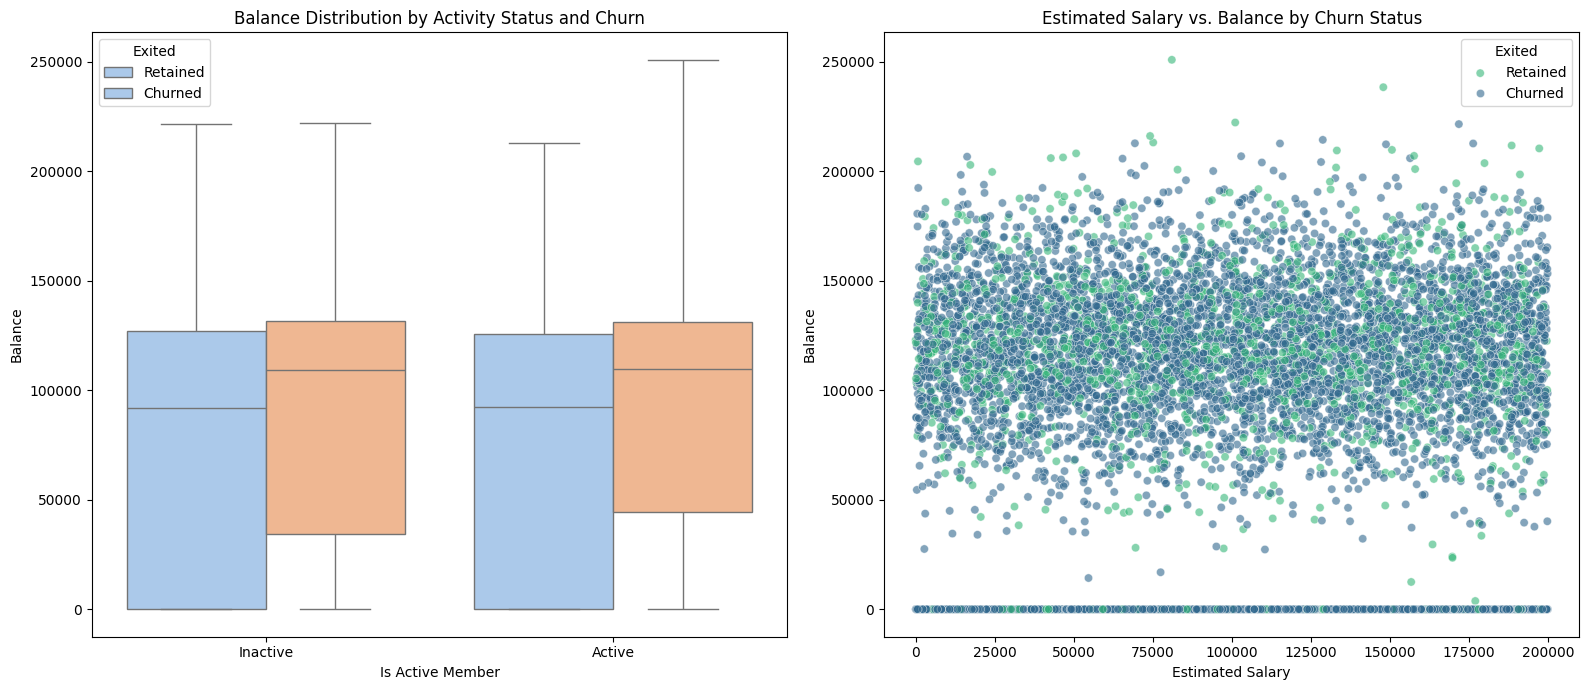

In [78]:
plt.figure(figsize=(16, 7))

# Box plot for Balance by IsActiveMember and Exited status
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.boxplot(x='IsActiveMember', y='Balance', hue='Exited', data=df, palette='pastel')
plt.xlabel('Is Active Member')
plt.ylabel('Balance')
plt.title('Balance Distribution by Activity Status and Churn')
plt.xticks(ticks=[0, 1], labels=['Inactive', 'Active'])
plt.legend(title='Exited', labels=['Retained', 'Churned'])

# Scatter plot for EstimatedSalary vs. Balance, colored by Exited status
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.scatterplot(x='EstimatedSalary', y='Balance', hue='Exited', data=df, palette='viridis', alpha=0.6)
plt.xlabel('Estimated Salary')
plt.ylabel('Balance')
plt.title('Estimated Salary vs. Balance by Churn Status')
plt.legend(title='Exited', labels=['Retained', 'Churned'])

plt.tight_layout()
plt.show()

**Reasoning**:
The next step is to display the head of the `at_risk_premium_customers` DataFrame and its shape to inspect the characteristics of these identified customers, as per the subtask instructions.



In [79]:
print("At-risk premium customers (head):")
print(at_risk_premium_customers.head())
print("\nShape of at-risk premium customers:", at_risk_premium_customers.shape)

At-risk premium customers (head):
    Year  CustomerId     Surname  CreditScore Geography  Gender  Age  Tenure  \
8   2025    15792365          He          501    France    Male   44       4   
9   2025    15592389          H?          684    France    Male   27       2   
15  2025    15643966     Goforth          616   Germany    Male   45       3   
26  2025    15736816       Young          756   Germany    Male   36       2   
28  2025    15728693  McWilliams          574   Germany  Female   43       3   

      Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
8   142051.07              2          0               1         74940.50   
9   134603.88              1          1               1         71725.73   
15  143129.41              2          0               1         64327.26   
26  136815.64              1          1               1        170041.95   
28  141349.43              1          1               1        100187.43   

    Exited  
8        0  
9 

**Reasoning**:
The first instruction is to display the calculated churn rate for 'sticky customers' by printing the `sticky_churn_rate` variable.



In [80]:
print("Churn rate for sticky customers:", sticky_churn_rate)

Churn rate for sticky customers: 0.05560098119378577


**Reasoning**:
The next step is to display the churn rates for all engagement profiles, including the 'sticky customer' profile, by printing the `churn_rates_all` Series.



In [81]:
print("Churn rates for all engagement profiles:\n", churn_rates_all)

Churn rates for all engagement profiles:
 Engagement_Profile
Active & Engaged              0.802817
Inactive & Disengaged         0.366521
Active but Low-Product        0.189231
Inactive but Multi-Product    0.162371
Sticky Customers              0.055601
Name: Exited, dtype: float64


**Reasoning**:
To visualize the churn rates across all engagement tiers, including the 'sticky customer' profile, I will create a bar chart using the `churn_rates_all` Series, with appropriate labels, title, and rotated x-axis labels for readability.



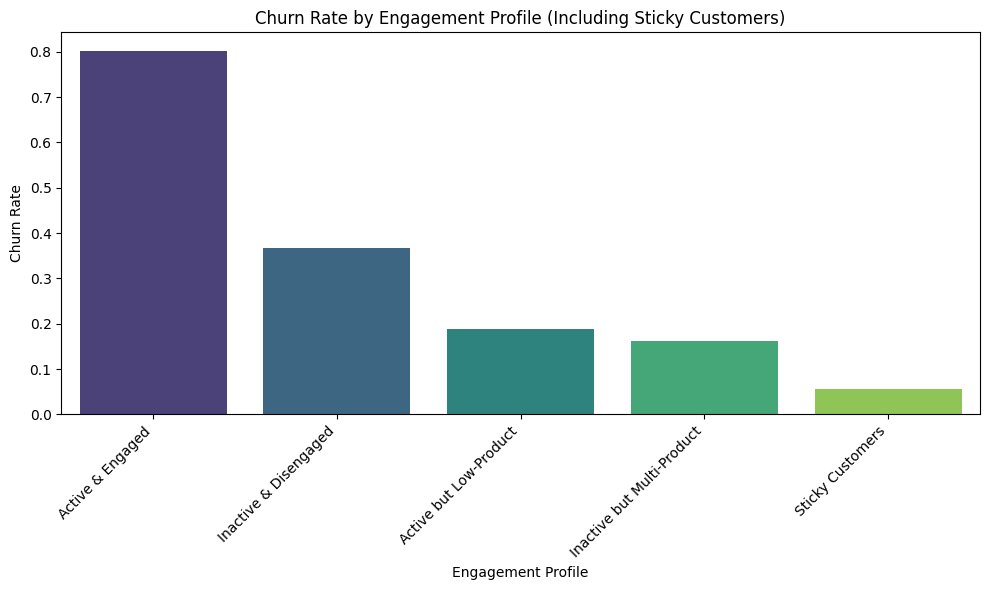

In [82]:
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_rates_all.index, y=churn_rates_all.values, hue=churn_rates_all.index, palette='viridis', legend=False)
plt.xlabel('Engagement Profile')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Engagement Profile (Including Sticky Customers)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [95]:
# Normalization helpers
df['TenureScore'] = (df['Tenure'] / df['Tenure'].max()) * 100
df['ProductScore'] = (df['NumOfProducts'] / df['NumOfProducts'].max()) * 100
df['ActiveScore'] = df['IsActiveMember'].apply(lambda x: 100 if x==1 else 0)




df['EngagementScore'] = (
    0.5*df['ActiveScore'] +
    0.3*df['ProductScore'] +
    0.2*df['TenureScore']
)

df['BalanceScore'] = (df['Balance'] / df['Balance'].max()) * 100
df['SalaryScore'] = (df['EstimatedSalary'] / df['EstimatedSalary'].max()) * 100

df['ValueScore'] = (
    0.6*df['BalanceScore'] +
    0.4*df['SalaryScore']
)

df['RetentionStrengthScore'] = (
    0.4*df['EngagementScore'] +
    0.3*df['ProductScore'] +
    0.2*df['ValueScore'] +
    0.1*df['TenureScore']
)
df[['EngagementScore', 'ValueScore', 'RetentionStrengthScore']].head()


,EngagementScore,ValueScore,RetentionStrengthScore
0,61.5,20.270538,38.154108
1,59.5,42.551251,40.810250
2,38.5,60.968601,58.093720
3,17.0,18.766032,26.553206
4,61.5,45.832188,43.266438


In [94]:
# Churn rate by credit card ownership
credit_card_churn = df.groupby('HasCrCard')['Exited'].mean()

credit_card_churn

# Credit Card Stickiness Score
credit_card_stickiness_score = (
    (1 - credit_card_churn[1]) * 100
)

print("Credit Card Stickiness Score:", round(credit_card_stickiness_score, 2))


Credit Card Stickiness Score: 79.82


In [93]:
def risk_bucket(score):
    if score <= 40:
        return "High Risk"
    elif score <= 65:
        return "Medium Risk"
    elif score <= 80:
        return "Stable"
    else:
        return "Strong"

df['RiskCategory'] = df['RetentionStrengthScore'].apply(risk_bucket)
df['RetentionRisk'] = df['RetentionStrengthScore'].apply(risk_bucket)
df['RetentionRisk'].value_counts()
df[['RetentionStrengthScore','RiskCategory']].head()

,RetentionStrengthScore,RiskCategory
0,38.154108,High Risk
1,40.810250,Medium Risk
2,58.093720,Medium Risk
3,26.553206,High Risk
4,43.266438,Medium Risk


In [86]:
app_content = '''
import streamlit as st
import pandas as pd

# Load the dataset within the Streamlit app environment
df = pd.read_csv('European_Bank.csv')

# --- Re-create necessary derived columns ---

# Engagement Profile
def create_engagement_profile(row):
    if row['IsActiveMember'] == 1 and row['NumOfProducts'] == 2:
        return 'Sticky Customers'
    elif row['IsActiveMember'] == 0 and row['NumOfProducts'] == 1:
        return 'Inactive & Disengaged'
    elif row['IsActiveMember'] == 1 and row['NumOfProducts'] == 1:
        return 'Active but Low-Product'
    elif row['IsActiveMember'] == 0 and row['NumOfProducts'] > 1:
        return 'Inactive but Multi-Product'
    elif row['IsActiveMember'] == 1 and row['NumOfProducts'] > 2:
        return 'Active & Engaged'
    else:
        return 'Other'
df['Engagement_Profile'] = df.apply(create_engagement_profile, axis=1)

# Product Category
df['ProductCategory'] = df['NumOfProducts'].apply(lambda x: 'Single-Product' if x == 1 else 'Multi-Product')

# Normalization helpers for scores
df['TenureScore'] = (df['Tenure'] / df['Tenure'].max()) * 100
df['ProductScore'] = (df['NumOfProducts'] / df['NumOfProducts'].max()) * 100
df['ActiveScore'] = df['IsActiveMember'].apply(lambda x: 100 if x==1 else 0)

# Engagement Score
df['EngagementScore'] = (
    0.5*df['ActiveScore'] +
    0.3*df['ProductScore'] +
    0.2*df['TenureScore']
)

# Balance and Salary Scores
df['BalanceScore'] = (df['Balance'] / df['Balance'].max()) * 100
df['SalaryScore'] = (df['EstimatedSalary'] / df['EstimatedSalary'].max()) * 100

# Value Score
df['ValueScore'] = (
    0.6*df['BalanceScore'] +
    0.4*df['SalaryScore']
)

# Retention Strength Score
df['RetentionStrengthScore'] = (
    0.4*df['EngagementScore'] +
    0.3*df['ProductScore'] +
    0.2*df['ValueScore'] +
    0.1*df['TenureScore']
)

# Risk Bucket
def risk_bucket(score):
    if score <= 40:
        return "High Risk"
    elif score <= 65:
        return "Medium Risk"
    elif score <= 80:
        return "Stable"
    else:
        return "Strong"
df['RiskCategory'] = df['RetentionStrengthScore'].apply(risk_bucket)
df['RetentionRisk'] = df['RetentionStrengthScore'].apply(risk_bucket)


# --- Streamlit App Layout ---
st.set_page_config(layout="wide")

st.title("Customer Engagement & Retention Strategy Dashboard")
st.markdown("### Analyze customer churn, engagement, and retention risks.")

# Sidebar for Filters
st.sidebar.header("Filters")

min_engagement = st.sidebar.slider("Min Engagement Score", 0, 100, 30)
min_products = st.sidebar.slider("Min Products", 1, 4, 1)
min_balance = st.sidebar.slider("Min Balance", 0, int(df['Balance'].max()), 0)
min_salary = st.sidebar.slider("Min Salary", 0, int(df['EstimatedSalary'].max()), 0)

filtered_df = df[
    (df['EngagementScore'] >= min_engagement) &
    (df['NumOfProducts'] >= min_products) &
    (df['Balance'] >= min_balance) &
    (df['EstimatedSalary'] >= min_salary)
]

# --- Dashboard Tabs ---
tab1, tab2, tab3 = st.tabs(["Overview", "High-Value Customers", "Retention Risk Analysis"])

with tab1:
    st.header("Overall Customer Metrics")
    col1, col2, col3 = st.columns(3)
    col1.metric("Total Customers", len(filtered_df), delta="", delta_color="off")
    col2.metric("Churn Rate (%)", round(filtered_df['Exited'].mean() * 100, 2), delta="", delta_color="off")
    col3.metric("Avg Retention Strength Score", round(filtered_df['RetentionStrengthScore'].mean(), 2), delta="", delta_color="off")

    st.subheader("Engagement Profile Churn Rates")
    churn_rates = filtered_df.groupby('Engagement_Profile')['Exited'].mean().sort_values(ascending=False) * 100
    st.bar_chart(churn_rates)

    st.subheader("Churn Rate by Product Category")
    churn_rate_by_category = filtered_df.groupby('ProductCategory')['Exited'].mean().sort_values(ascending=False) * 100
    st.bar_chart(churn_rate_by_category)

with tab2:
    st.header("Focus on High-Value Disengaged Customers")
    st.markdown("Customers with high 'ValueScore' but low 'EngagementScore' are critical for retention efforts.")

    high_value_disengaged = filtered_df[
        (filtered_df['ValueScore'] >= 70) &
        (filtered_df['EngagementScore'] <= 35)
    ]
    if not high_value_disengaged.empty:
        st.dataframe(high_value_disengaged.head())
        st.info(f"Found {len(high_value_disengaged)} high-value disengaged customers in current filter.")
    else:
        st.warning("No high-value disengaged customers found with the current filters.")

with tab3:
    st.header("Customer Retention Risk Distribution")
    st.markdown("Understanding the distribution of customers across different risk categories.")

    risk_counts = filtered_df['RetentionRisk'].value_counts().reindex(["High Risk", "Medium Risk", "Stable", "Strong"], fill_value=0)
    st.bar_chart(risk_counts)

    st.subheader("Average Balance by Activity and Churn Status")
    mean_balance_grouped = filtered_df.groupby(['IsActiveMember', 'Exited'])['Balance'].mean().unstack()
    st.dataframe(mean_balance_grouped)
'''

with open('app.py', 'w') as f:
    f.write(app_content)

print("app.py created successfully!")

app.py created successfully!


In [91]:
from pyngrok import ngrok
import os
from google.colab import userdata # Import userdata

# You need to get your ngrok Authtoken from https://ngrok.com/signup
# and add it to your Colab Secrets as 'NGROK_AUTH_TOKEN'
# Then run this cell to authenticate.

# Try getting from os.environ first
NGROK_AUTH_TOKEN = os.environ.get("NGROK_AUTH_TOKEN", "")

# If not found, try getting from google.colab.userdata
if not NGROK_AUTH_TOKEN:
    try:
        NGROK_AUTH_TOKEN = userdata.get("NGROK_AUTH_TOKEN")
        if NGROK_AUTH_TOKEN:
            print("NGROK_AUTH_TOKEN retrieved from Colab userdata.get().")
        else:
            print("NGROK_AUTH_TOKEN not found in Colab userdata.get() either.")
    except Exception as e:
        print(f"Error retrieving NGROK_AUTH_TOKEN from userdata.get(): {e}")
        NGROK_AUTH_TOKEN = "" # Ensure it's empty if not found due to error

print(f"Value retrieved for NGROK_AUTH_TOKEN: [{NGROK_AUTH_TOKEN}]")

if not NGROK_AUTH_TOKEN:
    print("Please add your NGROK_AUTH_TOKEN to Colab Secrets and ensure 'Notebook access' is enabled.")
else:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("ngrok authenticated successfully.")

# For debugging: print relevant environment variables
# print("\n--- Environment Variables (partial) ---")
# for k, v in os.environ.items():
#     if 'NGROK' in k.upper():
#         print(f"{k}: {v}")
# print("---------------------------------------")

NGROK_AUTH_TOKEN retrieved from Colab userdata.get().
Value retrieved for NGROK_AUTH_TOKEN: [39Q5icwKNuBKgzDECPqxPisfb5A_4BxUGm2sUwujW3NpCxuPQ]
ngrok authenticated successfully.


In [92]:
from pyngrok import ngrok
import subprocess
import os

# Kill any running ngrok tunnels to free up ports
!kill -9 $(lsof -t -i:8501) > /dev/null 2>&1
!kill -9 $(lsof -t -i:4040) > /dev/null 2>&1

# Start Streamlit in the background
streamlit_process = subprocess.Popen(["streamlit", "run", "app.py"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait a moment for Streamlit to start
import time
time.sleep(5)

# Open a ngrok tunnel to the Streamlit port (8501)
public_url = ngrok.connect(8501)
print(f"Streamlit App URL: {public_url}")


Streamlit App URL: NgrokTunnel: "https://ehtel-enormous-morphemically.ngrok-free.dev" -> "http://localhost:8501"


## Comprehensive Customer Churn Analysis: Key Findings & Strategic Insights

This analysis of the European Bank customer data aimed to identify key drivers of churn and classify customer engagement to inform retention strategies. The process involved data validation, engagement and product utilization analysis, financial commitment assessment, and retention strength scoring, culminating in an interactive dashboard.

### Key Findings:

1.  **Data Quality**: The dataset was found to be clean and complete, with no missing values and consistent data types across all columns. This ensures the reliability of our analysis.

2.  **Churn Patterns Related to Balance**:
    *   **High-Balance Churners**: A critical insight is that customers who churn, regardless of their active membership status, consistently exhibit **higher average balances** than those who are retained. Specifically, inactive churned customers had an average balance of approximately $90,988 (vs. $72,048 for retained), and active churned customers had about $91,320 (vs. $73,304 for retained). This indicates that the bank is losing its more financially significant customers.
    *   **At-Risk Premium Segment**: A substantial group of **1,908 high-value customers** (those in the top 25% balance bracket) were identified as being at risk of churning, representing a significant potential loss.

3.  **Product Utilization and Churn**:
    *   **Product Count Impact**: The number of products a customer holds is a strong indicator of churn risk. Customers with only one product (`Single-Product`) have a significantly higher churn rate (27.71%) compared to `Multi-Product` customers (12.77%).
    *   **Optimal Product Number**: Customers with **two products** exhibit the **lowest churn rate (7.58%)**. Conversely, customers with **three products (82.71%) and four products (100%) have extremely high churn rates**, suggesting dissatisfaction or an overwhelming product experience for these segments.

4.  **Customer Engagement Profiles and Churn Rates**:
    *   **'Sticky Customers' (Active & 2 Products)**: This group demonstrates the **lowest churn rate at ~5.56%**, highlighting the effectiveness of being an active member with an optimal number of products.
    *   **'Active & Engaged' (Active & >2 Products)**: Surprisingly, this segment shows the **highest churn rate at ~80.28%**. This aligns with the finding that 3+ products correlate with very high churn, indicating that simply being active with many products does not guarantee retention; it might even be a risk factor.
    *   **'Inactive & Disengaged'**: As expected, this group has a high churn rate of ~36.65%.

5.  **Retention Strength Scoring**: A `RetentionStrengthScore` was developed, categorizing customers into 'High Risk', 'Medium Risk', 'Stable', and 'Strong' groups, providing a comprehensive view of individual customer churn probability.

6.  **Credit Card Ownership**: Customers with a credit card show a high `Credit Card Stickiness Score` of ~79.82%, indicating that credit card holders are generally more loyal.

### Valuable Insights & Proposed Retention Strategies:

*   **Prioritize High-Value At-Risk Customers**: Implement a targeted, personalized outreach program for the 1,908 identified high-balance, non-churned customers. Offer exclusive benefits, relationship manager support, or tailored product recommendations.

*   **Optimize Product Portfolio and Bundling**:
    *   **Promote 2-Product Adoption**: Actively encourage single-product customers to adopt a second product, as this profile (

## Interactive Visualization: Streamlit Dashboard

For an interactive exploration of these findings, the Streamlit dashboard provides a dynamic interface to filter customer segments, visualize churn rates by engagement profiles and product categories, identify high-value disengaged customers, and analyze retention risk distribution.